In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
import matplotlib.cm as cm

from matplotlib import rcParams
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

%matplotlib inline

In [2]:
IMAGES_PATH = Path().resolve().parent / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction to clustering

Clustering is a machine learning technique used to group unlabeled datapoints in groups called *clusters*. The grouping is done such that similar items are together in the same cluster and items in different clusters are dissimilar from each-other. Typically similarity is defined using a distance measure (Euclidean, cosine, etc). Common practical applications for clustering include: market segmentation, social network analysis, search result grouping, anomaly detection etc.


Two clustering methods will be explored in this notebook:

- K-means.
- Hierarchical clustering.

More methods can be found [here](https://scikit-learn.org/stable/modules/classes.html?highlight=cluster#module-sklearn.cluster).

#### To begin with
Get familiar with how clustering works by watching the videos in Resources A and reading the article in Resources B.


#### Resources: 

* A. Introduction to clustering:
    * https://www.youtube.com/watch?v=4cxVDUybHrI
    
    
* B. A Comprehensive Survey of Clustering Algorithms
    * https://link.springer.com/article/10.1007/s40745-015-0040-1 (Read everything until the section Traditional Clustering Algorithms. From the section Traditional Clustering Algorithms, read the first 2 subsections. You can skip Modern Traditional Clustering Algorithms.)



* C. K-means clustering:
     * https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
     
     * https://www.youtube.com/watch?v=QXOkPvFM6NU&t=1s (up to minute 11:34)
     
     
* D. Hierarchical clustering:
    * https://www.youtube.com/watch?v=QXOkPvFM6NU&t=1s (from minute 11:34 onwards)
    * https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/ (example on how to do hierarchical clustering with scikit-learn)
    * https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering 

### Subject comprehension 

To check your understanding, before moving further, answer the questions in your own words in the space below.

1. What is clustering?
2. What are the main steps in the standard process of clustering?
3. What is the Silhouette coefficient?
4. What are the two types of evaluation for a clustering algorithm and what is the difference between them?

*Answer here*

### Data acquisition

Load the data about bank clients from the *bank-full.csv* file into a pandas dataframe. Make the necessary imports.

In [3]:
# code here
data_path = Path().resolve().parent / "data"

df = pd.read_csv(data_path/"bank-full.csv", delimiter=";")

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Print a summary of the data as well as the first 5 rows.

In [4]:
# code here

df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Preprocessing

To facilitate the computation of distances, keep only the numerical features in the dataset.

- Remove all non-numerical features, as well as the features related to the date.
- Make sure there are no missing values - if they exist, remove them.
- Normalize the new dataset (transform the data for multiple features to the same scale).
- Save the result in a dataframe *df_norm*

In [5]:
# code here

categorical_features = [col for col in df.select_dtypes(include="object").columns]
numerical_features = [col for col in df.select_dtypes(include="number").columns]

df = df.drop(categorical_features, axis=1)
df.drop("day", axis=1, inplace=True)
df.head()

,age,balance,duration,campaign,pdays,previous
0,58,2143,261,1,-1,0
1,44,29,151,1,-1,0
2,33,2,76,1,-1,0
3,47,1506,92,1,-1,0
4,33,1,198,1,-1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       45211 non-null  int64
 1   balance   45211 non-null  int64
 2   duration  45211 non-null  int64
 3   campaign  45211 non-null  int64
 4   pdays     45211 non-null  int64
 5   previous  45211 non-null  int64
dtypes: int64(6)
memory usage: 2.1 MB


In [7]:
scaler = StandardScaler().set_output(transform="pandas")
df_scaled = scaler.fit_transform(df)
df_scaled

,age,balance,duration,campaign,pdays,previous
0,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.251940
1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.251940
2,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.251940
3,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.251940
4,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.251940
...,...,...,...,...,...,...
45206,0.947747,-0.176460,2.791329,0.076230,-0.411453,-0.251940
45207,2.831227,0.120447,0.768224,-0.246560,-0.411453,-0.251940
45208,2.925401,1.429593,3.373797,0.721811,1.436189,1.050473
45209,1.512791,-0.228024,0.970146,0.399020,-0.411453,-0.251940


Plot histograms of features

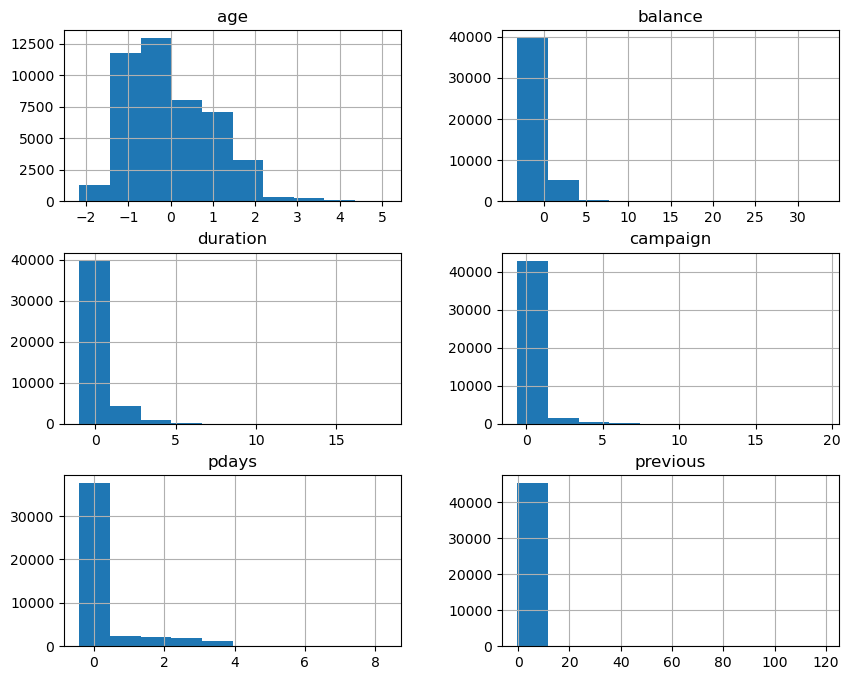

In [8]:
# code here
rcParams['figure.figsize'] = 10,8
plots = df_scaled.hist()

In [9]:
df_scaled.to_csv(data_path/"df_norm.csv", index=False)

In [10]:
data_path = Path().resolve().parent / "data"

df_norm = pd.read_csv(data_path/"df_norm.csv")
df_norm.head()

,age,balance,duration,campaign,pdays,previous
0,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.25194
1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.25194
2,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.25194
3,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.25194
4,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.25194


## KMeans


Let's warm up with the well known algorithm named KMeans!

Centroid-based clustering organizes the data into non-hierarchical clusters, contrarily to hierarchical clustering. KMeans is the most widely-used centroid-based clustering algorithm. Centroid-based algorithms are efficient but sensitive to initial conditions and outliers. 


To better understand the way the algorithm works, read the documents and watch the video in Resources C:
* https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
* https://www.youtube.com/watch?v=QXOkPvFM6NU&t=1s (up to minute 11:34)


Then answer the below questions (in your own words):
1. What is a centroid?
2. How can you compute a centroid?
3. Are you supposed to know in advance the number of clusters in order to use the KMeans algorithm?


*Answer here*

#### Make the necessary imports from scikit learn in order to perform KMeans clustering

#### Exploring KMeans with sklearn

The goal of this step is to become familiar with the sklearn clustering package and the silhouette analysis concepts.

Start by performing a clustering of the data in *df_norm* into 5 clusters.

In [11]:
# code here

kmeans = KMeans(n_clusters=5, random_state=1917, n_init="auto")
kmeans.fit(df_norm)

KMeans(n_clusters=5, random_state=1917)

Print the centroids obtained

In [12]:
# code here
centroids  = kmeans.cluster_centers_
centroids

array([[-0.06519157,  0.04379495,  2.55705013, -0.1059173 , -0.26032932,
        -0.15687368],
       [ 1.10075584,  0.23994588, -0.23737833, -0.10649855, -0.32637185,
        -0.18511715],
       [-0.1478702 , -0.01156824, -0.09648224, -0.20724716,  2.23109029,
         1.29951533],
       [-0.64475187, -0.15044914, -0.22442599, -0.15602427, -0.37487647,
        -0.22010303],
       [-0.06731762, -0.09481349, -0.45716319,  3.92952641, -0.40159077,
        -0.24080863]])

Print the cluster labels assigned to each point

In [13]:
# code here
labels = kmeans.predict(df_norm)
labels

array([1, 3, 3, ..., 0, 1, 2], dtype=int32)

In [14]:
"""
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(df_norm.iloc[:,0], df_norm.iloc[:,1], df_norm.iloc[:,2],
            df_norm.iloc[:,3],
            df_norm.iloc[:,4],
            df_norm.iloc[:,5],
            alpha=.1)

plt.scatter(centroids_x, centroids_y, 
            marker="x", 
            s=150,
            linewidths=5, 
            zorder=10, 
            )
"""

'\ncentroids_x = centroids[:,0]\ncentroids_y = centroids[:,1]\n\nplt.scatter(df_norm.iloc[:,0], df_norm.iloc[:,1], df_norm.iloc[:,2],\n            df_norm.iloc[:,3],\n            df_norm.iloc[:,4],\n            df_norm.iloc[:,5],\n            alpha=.1)\n\nplt.scatter(centroids_x, centroids_y, \n            marker="x", \n            s=150,\n            linewidths=5, \n            zorder=10, \n            )\n'

### **Visualization**

Let's try to visualize the created clusters. As it is easier to visualize 2-dimensional data, first run PCA on the data. Then create a scatterplot to visualize the clustered points, each coloured differently depending on the cluster they belong to.

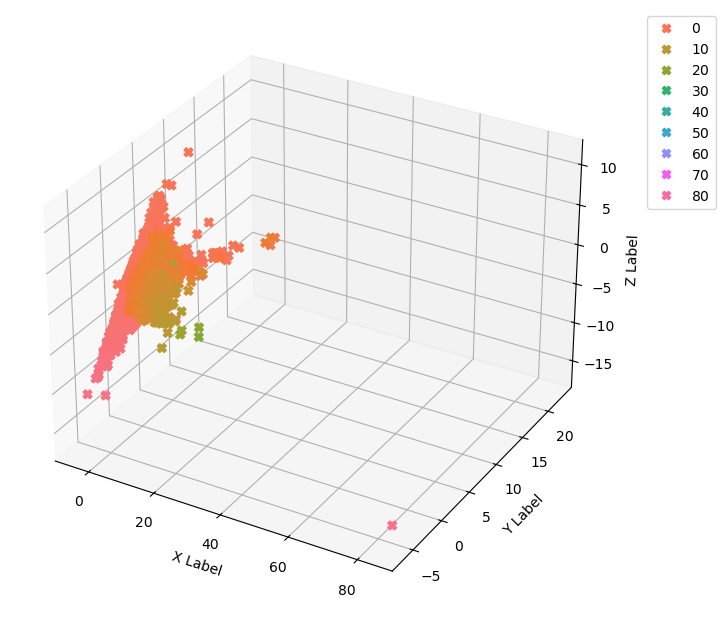

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# code here

pca = PCA(3)
pca_data = pd.DataFrame(pca.fit_transform(df_norm),
                        columns=["PC1", "PC2", "PC3"])

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

x=pca_data["PC1"]
y=pca_data["PC2"]
z=pca_data["PC3"]

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='X', cmap=cmap, alpha=1, data=pca_data)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

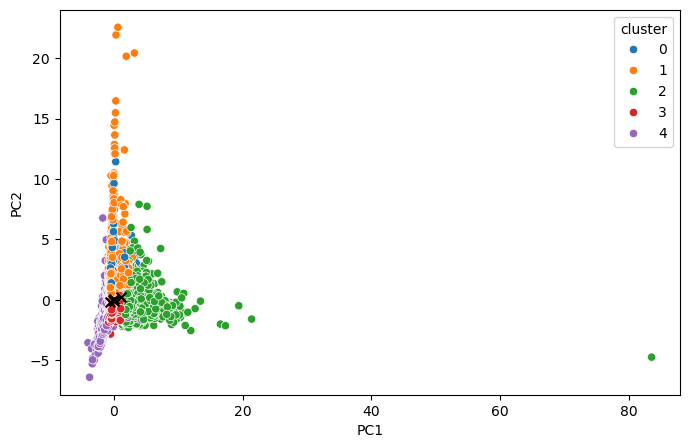

In [17]:
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(df_norm),
                        columns=["PC1", "PC2"])

pca_data["cluster"] = pd.Categorical(kmeans.labels_)

rcParams['figure.figsize'] = 8,5

sns.scatterplot(x="PC1",
                y="PC2",
                hue="cluster",
                data=pca_data)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker="x", color='k', s=50)

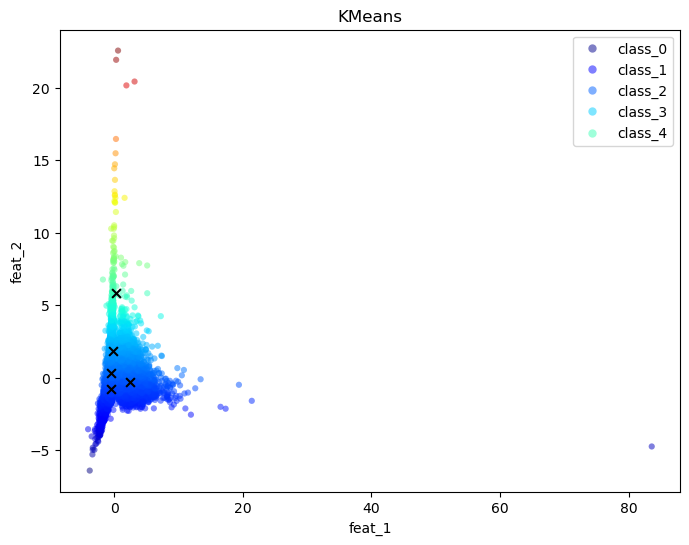

In [18]:
pca = PCA(2)
df_pca = pca.fit_transform(df_norm)

k_means = KMeans(n_clusters=5, random_state=42)
k_means = k_means.fit(df_pca)
kmeans_labels = k_means.predict(df_pca)

target_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']

plt.figure(figsize=(8,6))
plot = plt.scatter(df_pca[:,0],df_pca[:,1],c=y,s=20, cmap=plt.cm.jet, linewidths=0, alpha=0.5)
plt.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1], marker="x", color='k', s=40)
plt.legend(handles=plot.legend_elements()[0], labels=list(target_names))
plt.xlabel('feat_1')
plt.ylabel('feat_2')
plt.title('KMeans')
plt.show()

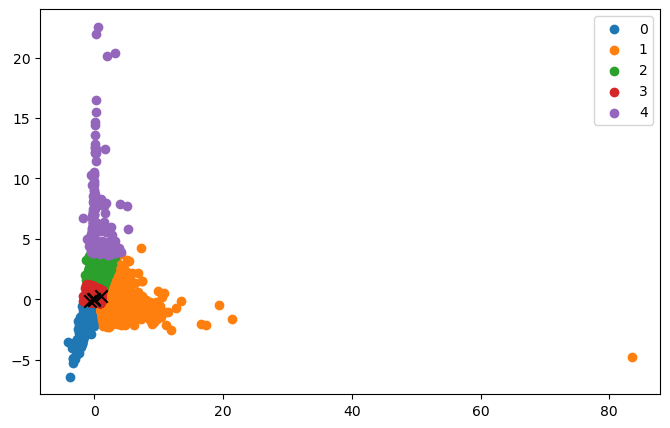

In [20]:
u_labels = np.unique(kmeans_labels)
centroids = kmeans.cluster_centers_

for i in u_labels:
    plt.scatter(df_pca[kmeans_labels==i, 0],
                df_pca[kmeans_labels==i, 1],
                label=i)

plt.scatter(centroids[:,0], centroids[:,1],
            s=80,
            marker="x",
            color="k")

plt.legend()
plt.show()

### Evaluation

**Inertia** can be a measure of how internally coherent clusters are. It represents the within-cluster sum-of-squares.

Read more about it here:
https://scikit-learn.org/stable/modules/clustering.html#k-means 

Print the inertia obtained after the clustering.

In [21]:
# code here
k_means.inertia_

34375.26941047339

**The silhouette score**

Make the necessary imports from scikit learn and compute the silhouette score.

Read what this score represents and how it is computed here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html and here https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [22]:
# code here

silhouette_score(df_pca, kmeans_labels)

0.46458813375438796

In [163]:
"""Resumo dos codigos acima"""

#pcaa = PCA(2)
#df_pcaa = pca.fit_transform(df_norm)

#k_meansss = KMeans(n_clusters=5, random_state=42)
#silhouette_score(df_pcaa, k_meansss.fit_predict(df_pcaa))

0.46458813375438796

In [167]:
silhouette_samples(df_pca, kmeans_labels, metric='euclidean')

array([0.24585271, 0.35419634, 0.64519218, ..., 0.17633419, 0.30109318,
       0.52970981])

You can read more about other clustering evaluation methods here: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

### Finding the optimal number of clusters

In the following article you will find several [methods](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) for determining the number of clusters.

We will first use the silhouette score for obtaining the optimal number of clusters. Optional: another method you can try is the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) ).


**Use the silhouette analysis to find an optimal number of clusters for the bank clients data.** <u><i>Hint:</u></i> Feel free to use the `n_jobs` hyperparameter to speed up your computation.

An example of silhouette analysis is presented here: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Plot the silhouette scores for 20 different numbers of clusters of your choice.

For n_clusters = 2 The average silhouette_score is : 0.34887971874957835
For n_clusters = 3 The average silhouette_score is : 0.5095285055919015
For n_clusters = 4 The average silhouette_score is : 0.5140800106997256
For n_clusters = 5 The average silhouette_score is : 0.48751933338091885
For n_clusters = 6 The average silhouette_score is : 0.4731978206389546
For n_clusters = 7 The average silhouette_score is : 0.4275156603121119
For n_clusters = 8 The average silhouette_score is : 0.4599746078871401
For n_clusters = 9 The average silhouette_score is : 0.4218596436776935
For n_clusters = 10 The average silhouette_score is : 0.43886932782422683
For n_clusters = 11 The average silhouette_score is : 0.4381551972839853
For n_clusters = 12 The average silhouette_score is : 0.4364902792252766
For n_clusters = 13 The average silhouette_score is : 0.44477350217711803
For n_clusters = 14 The average silhouette_score is : 0.42233568324177945
For n_clusters = 15 The average silhouette_score is : 

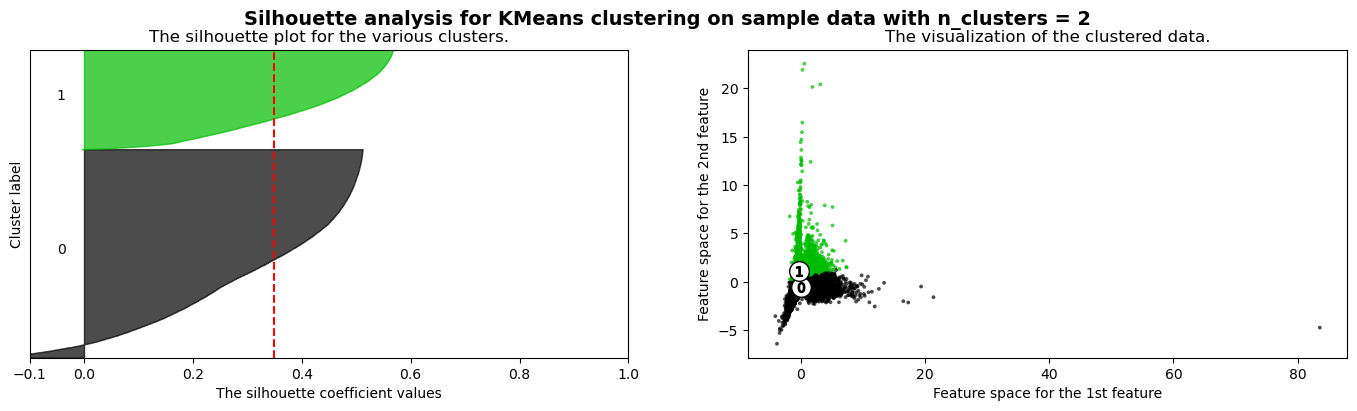

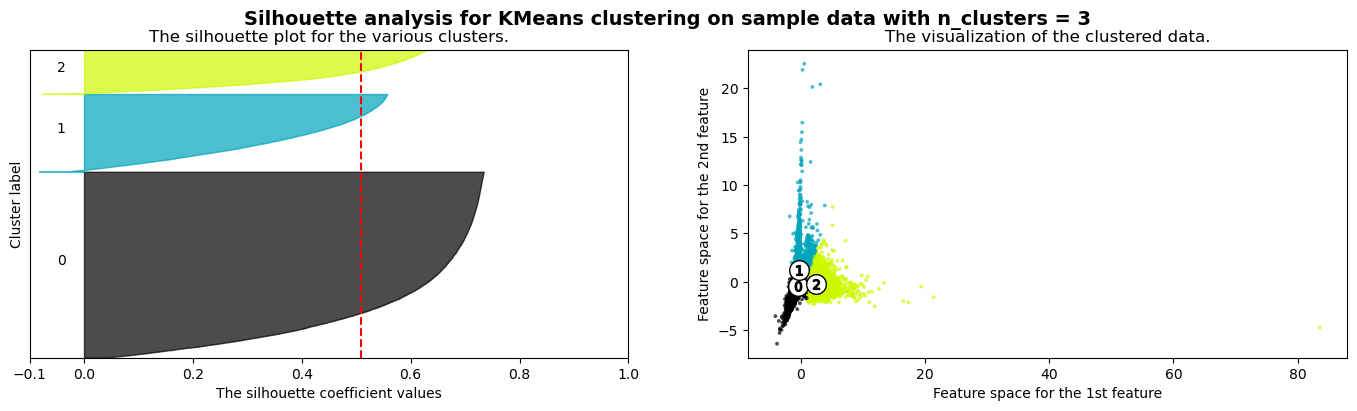

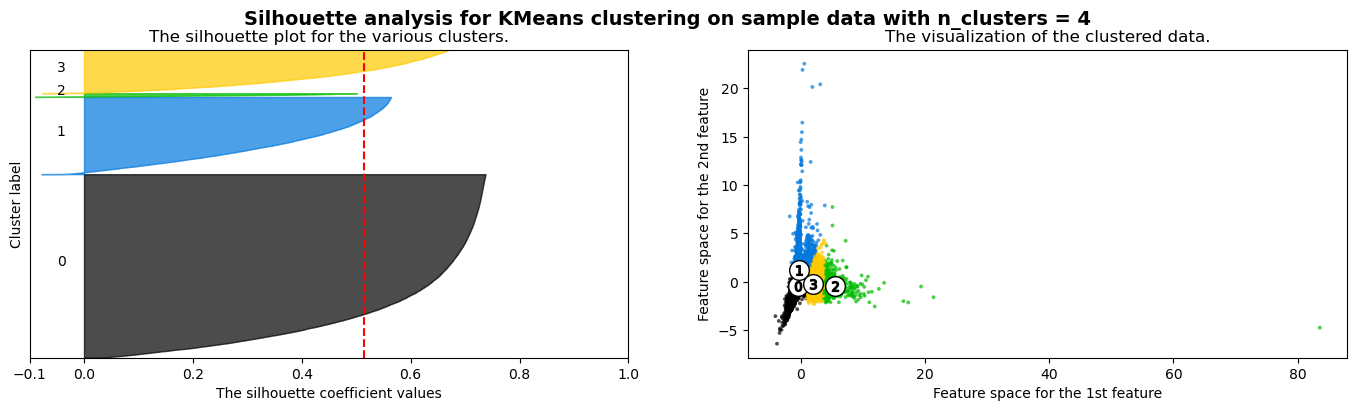

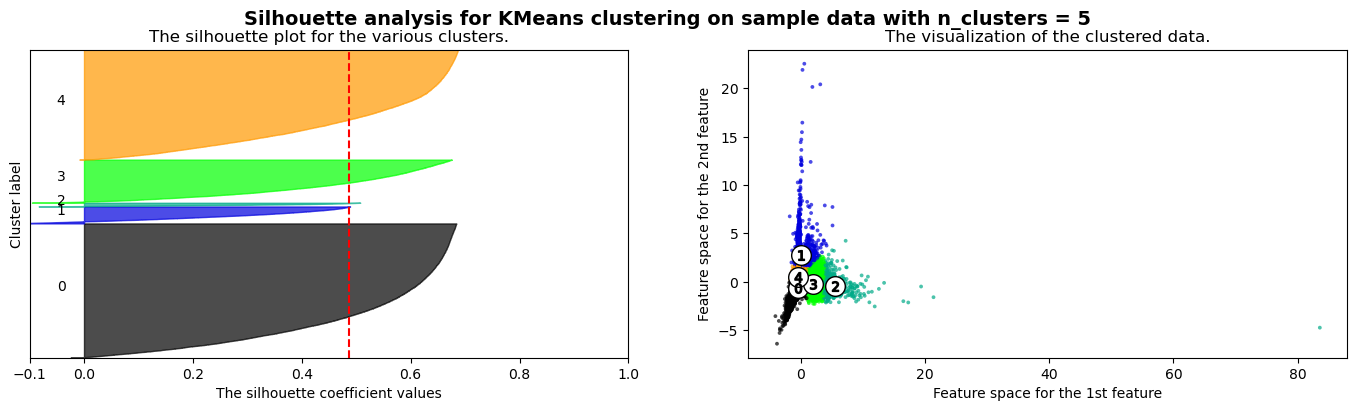

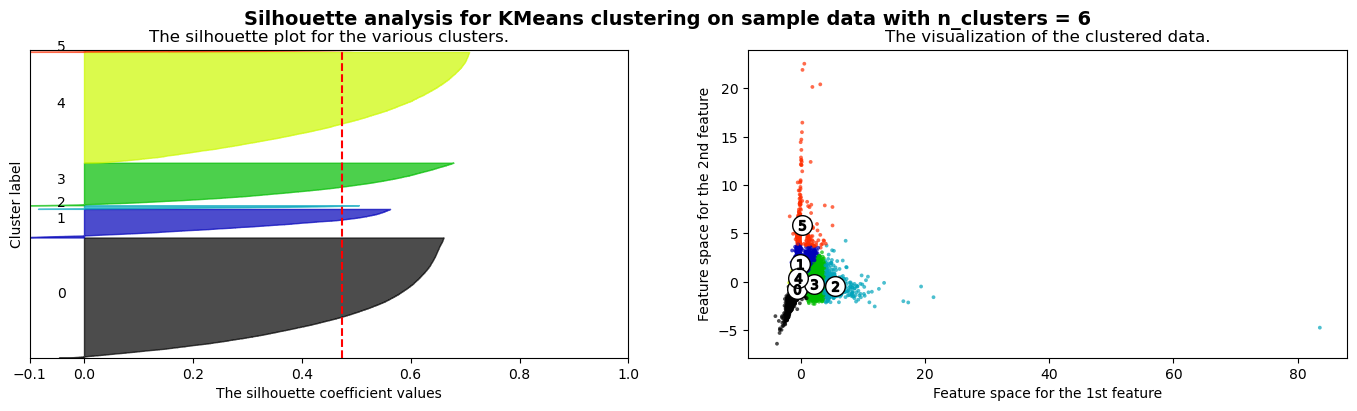

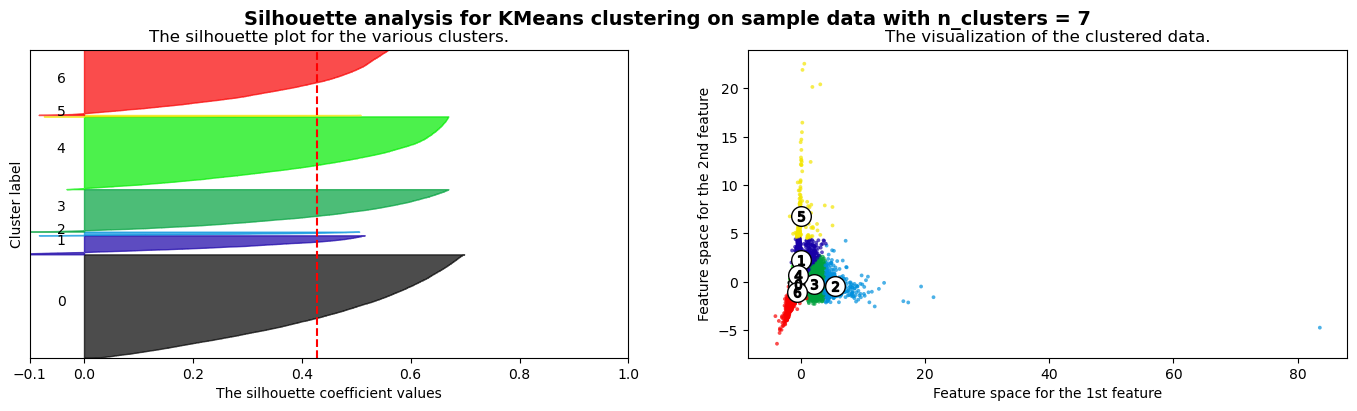

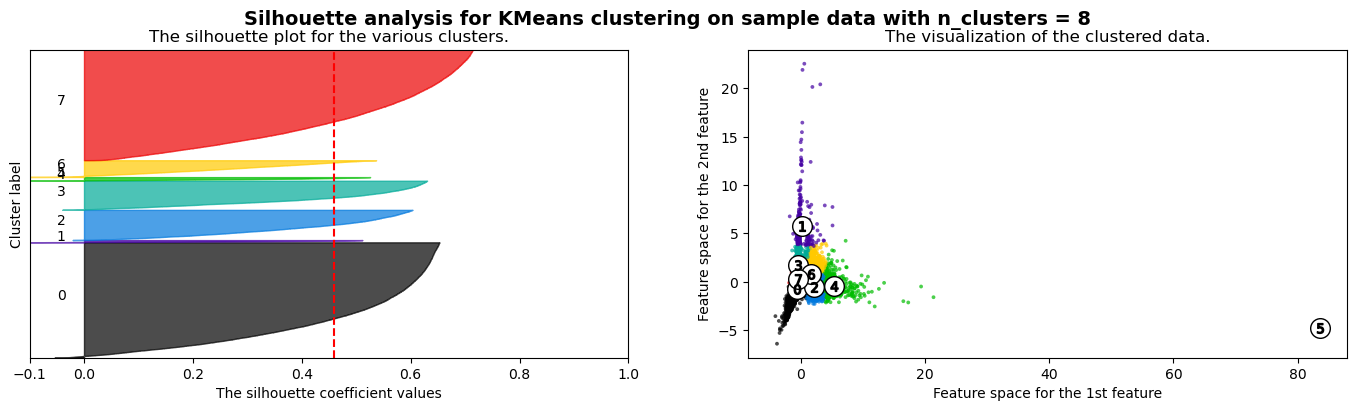

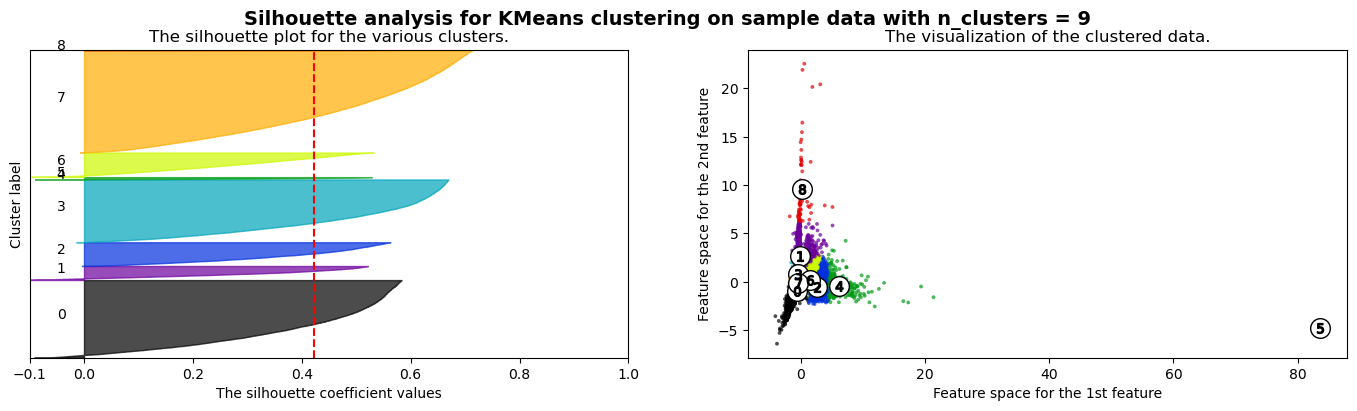

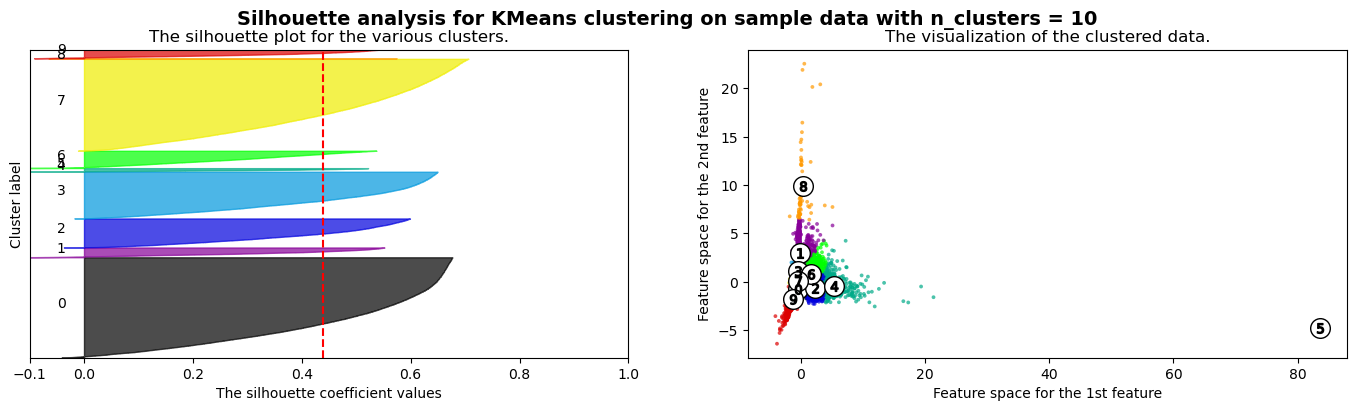

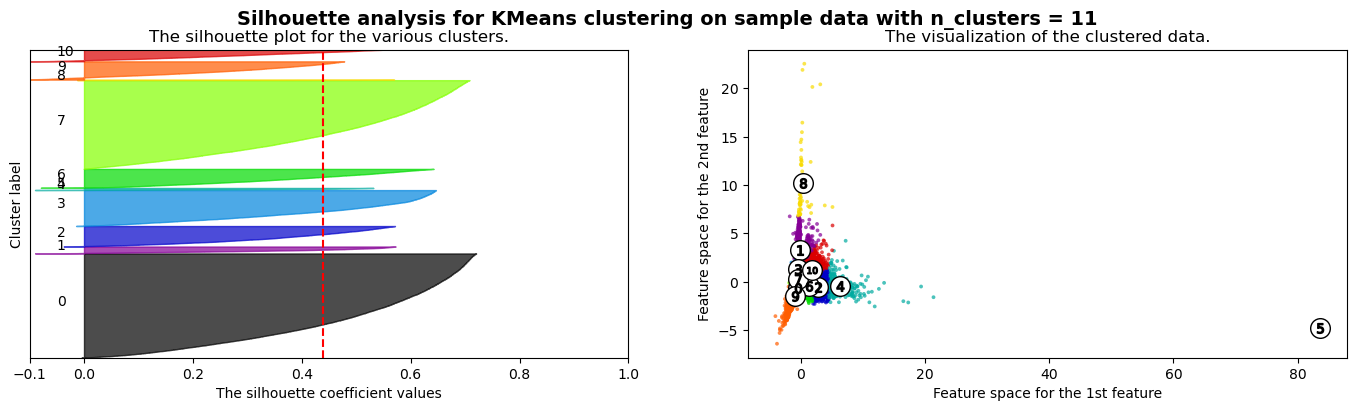

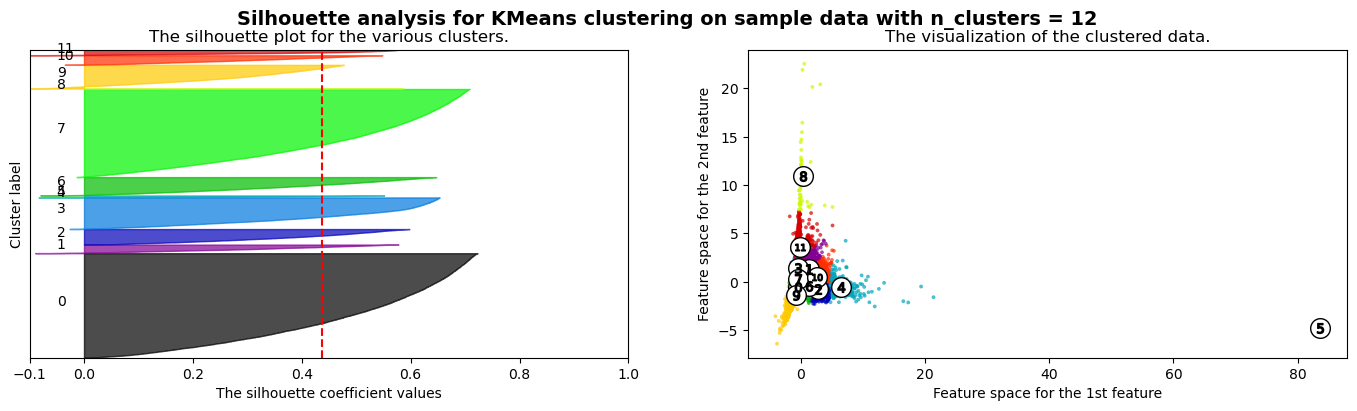

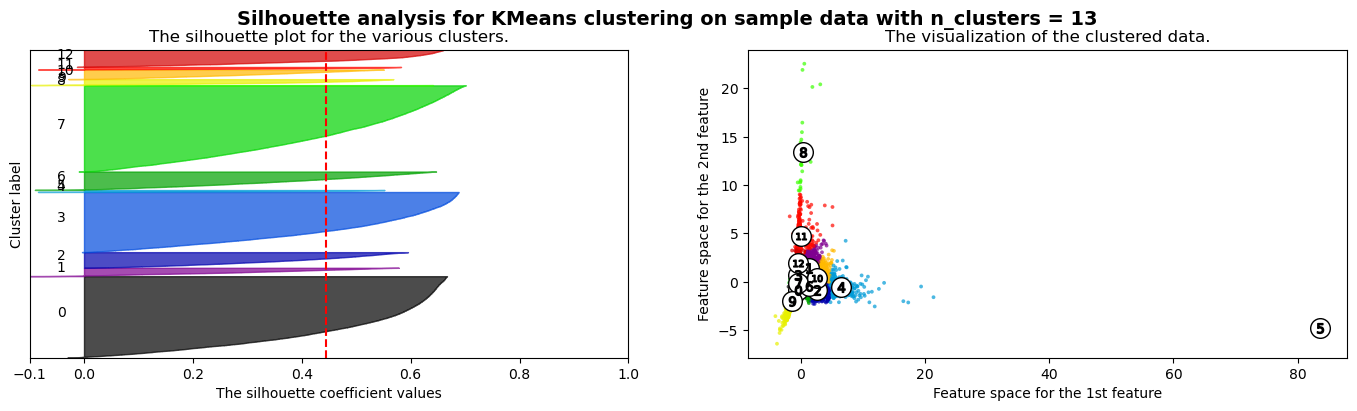

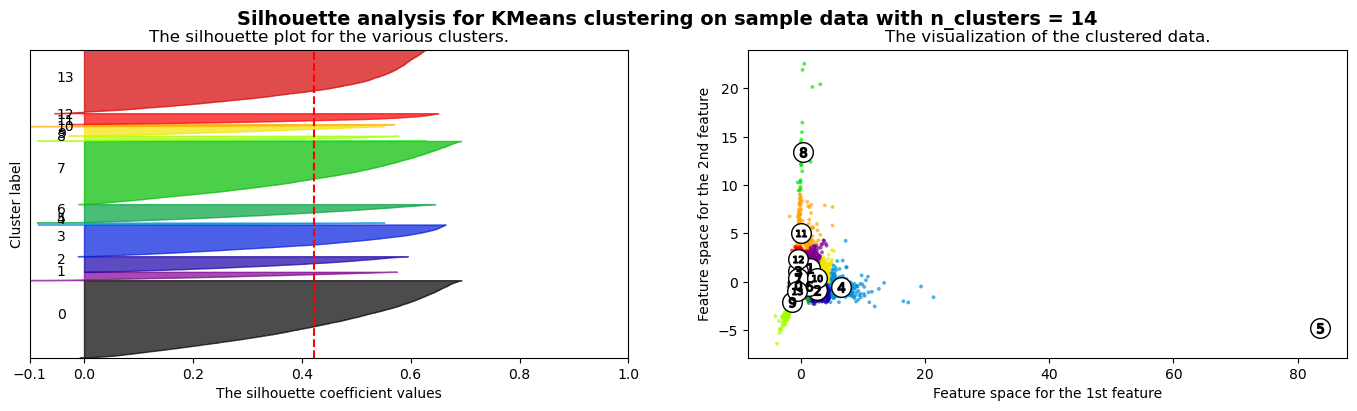

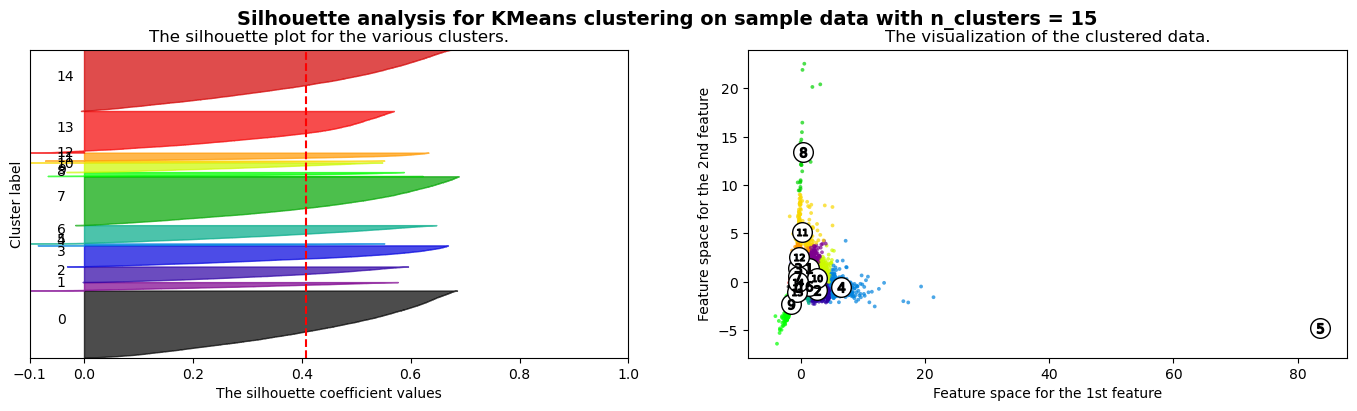

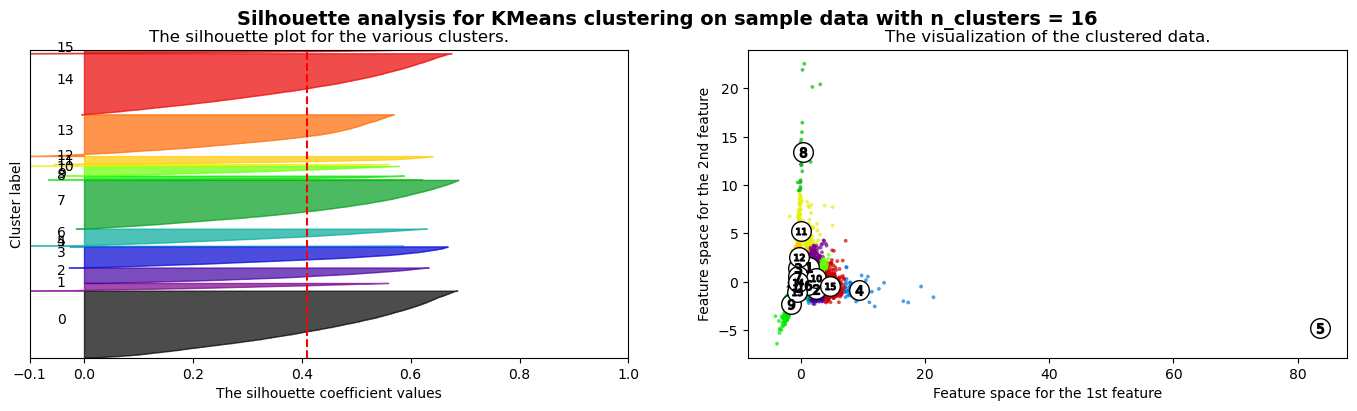

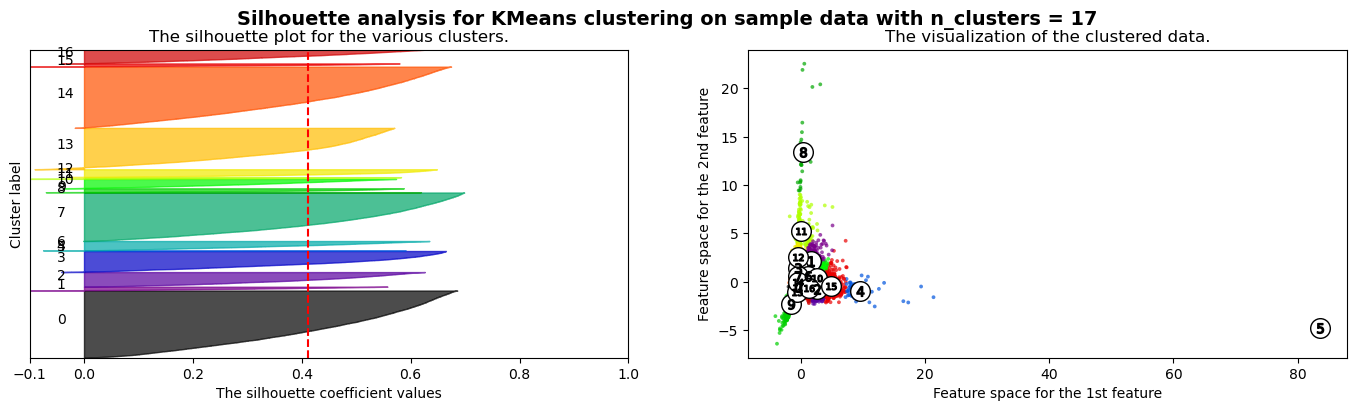

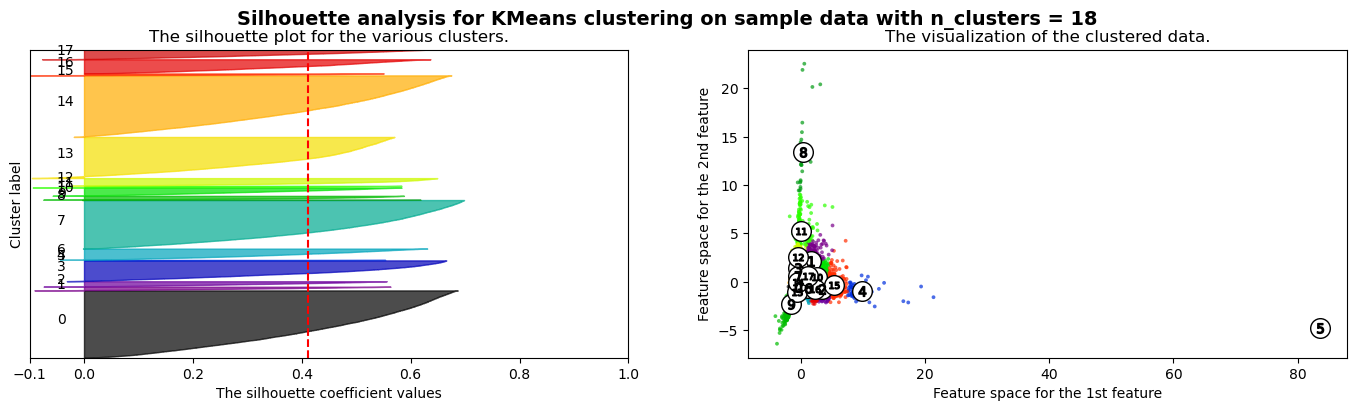

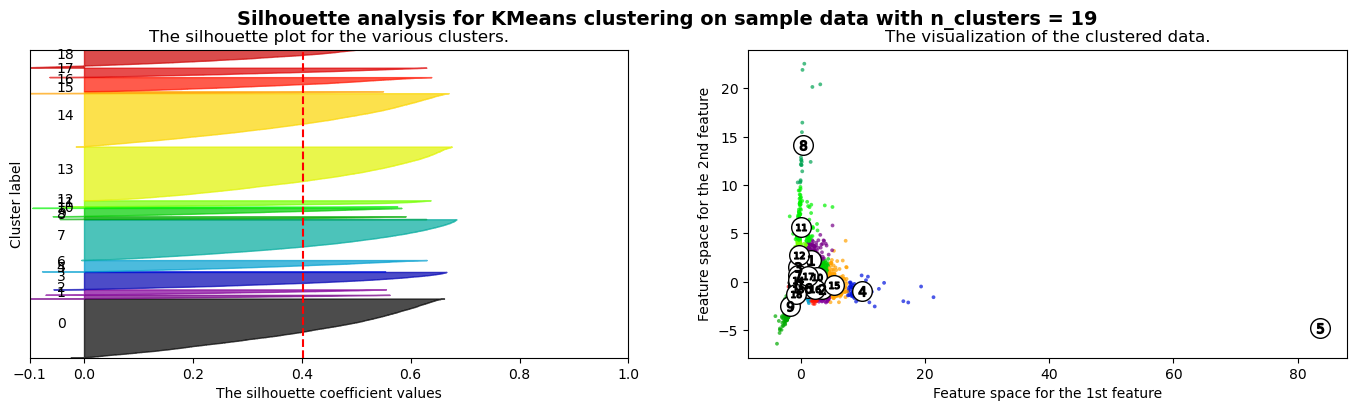

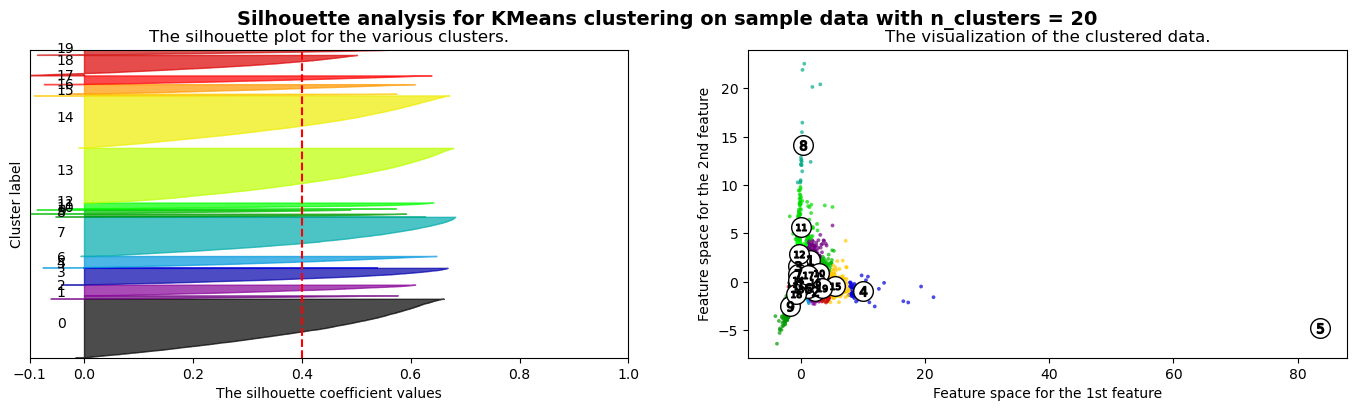

In [27]:
# code here

range_n_clusters = range(2, 21)

wcss = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(17, 4)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=1917)
    cluster_labels = clusterer.fit_predict(df_pca)

    wcss.append(clusterer.inertia_)

    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_pca[:, 0], df_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Text(0, 0.5, 'WCSS')

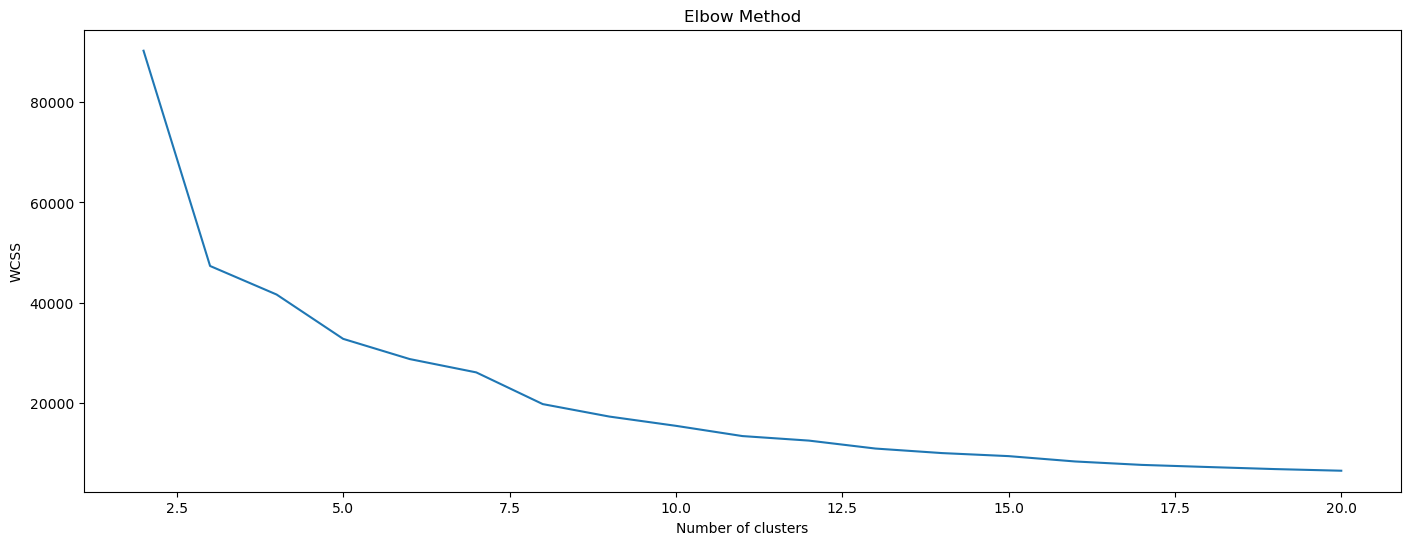

In [28]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
#    fig.set_size_inches(17, 4)

plt.figure(figsize=(17, 6))
plt.plot(range(2, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

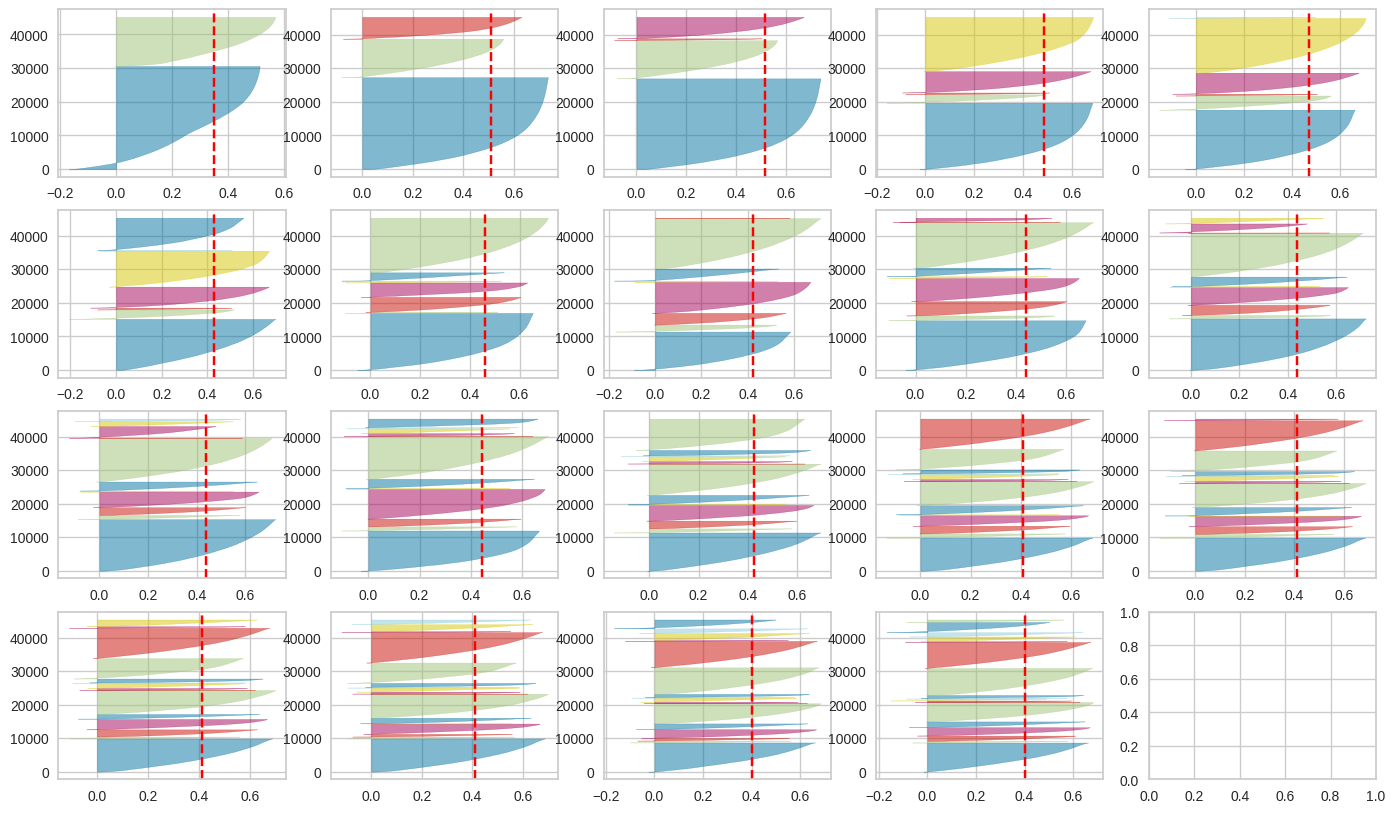

In [51]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(4, 5, figsize=(17, 10))
i = 0
j = 0

for n in range(2, 21):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=n, random_state=1917)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[i][j])
    visualizer.fit(df_pca)

    if j == 4:
        i += 1
        j = 0
    else:
        j += 1

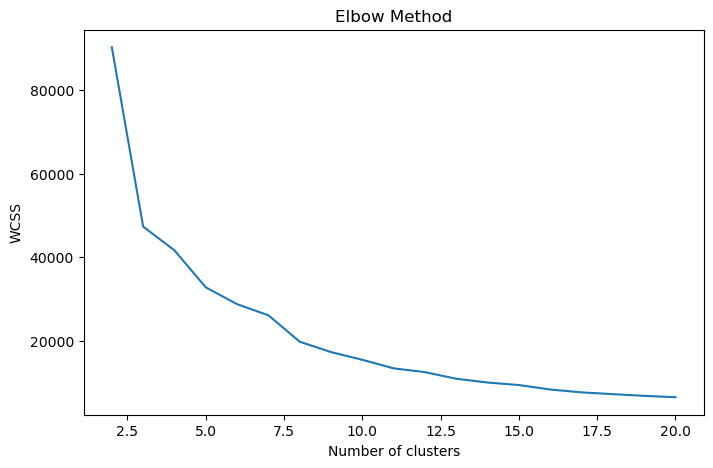

In [29]:
wcss = []

for i in range(2, 21):

    km = KMeans(n_clusters=i, random_state=1917)
    km.fit(df_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

What is the optimal number of clusters that you obtained?

*Answer here*

## Hierarchical Clustering

Let's try to apply now a different method on the same data. You can find more explanations on hierarchical clustering in the links in section Resources D. Hierarchical clustering:
 * https://www.youtube.com/watch?v=QXOkPvFM6NU&t=1s (from minute 11:34 onwards)
 * https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/ (example on how to do hierarchical clustering with scikit-learn)
 * https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

Make the necessary imports from scikit learn to perform hierarchical clustering. 

Start by plotting the dendrogram and deciding the number of clusters. Then apply hierarchical clustering.

You might find this useful: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html for creating the dendrogram.

In [30]:
data_path = Path().resolve().parent / "data"

df_norm = pd.read_csv(data_path/"df_norm.csv")
df_norm.head()

,age,balance,duration,campaign,pdays,previous
0,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.25194
1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.25194
2,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.25194
3,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.25194
4,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.25194


In [31]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

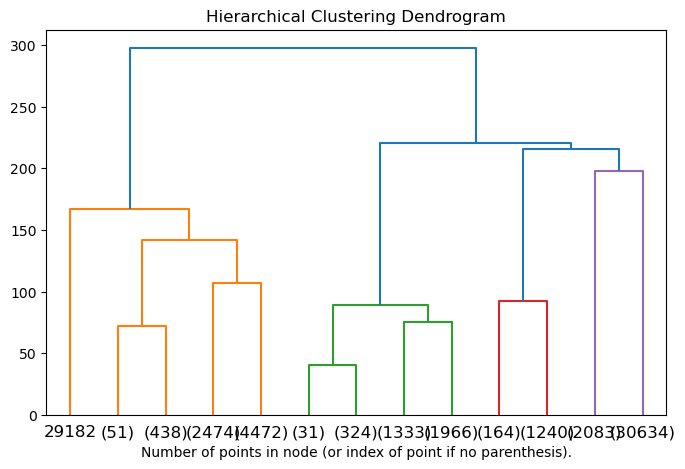

In [32]:
#from sklearn.cluster import AgglomerativeClustering
#from scipy.cluster.hierarchy import dendrogram

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_norm)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

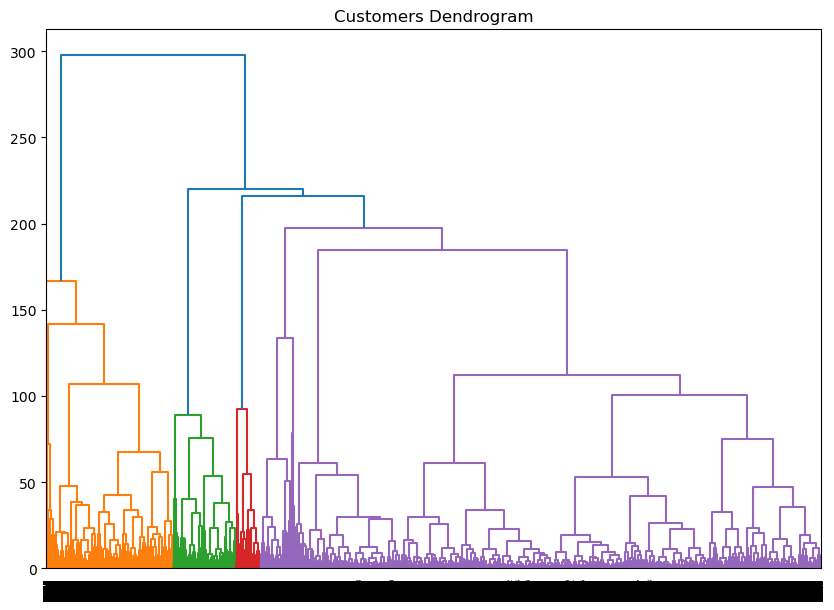

In [35]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

clusters = shc.linkage(df_norm, 
                       method='ward', 
                       metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

How many clusters did you find?

5??

Compare the kmeans labels with the labels obtained by the hierarchical clustering.

In [40]:
pca = PCA(2)
df_pca_hyer = pca.fit_transform(df_norm)

clustering_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering_model.fit(df_pca_hyer)

AgglomerativeClustering(n_clusters=5)

In [41]:
clustering_model.labels_

array([2, 1, 3, ..., 2, 2, 0])

In [48]:
df_pd_pca_hyer = pd.DataFrame(df_pca_hyer)
df_pd_pca_hyer

,0,1
0,-0.393449,1.337244
1,-0.391030,-0.065795
2,-0.371132,-0.796502
3,-0.392309,0.352096
4,-0.354773,-0.639436
...,...,...
45206,-0.411889,1.395701
45207,-0.467420,2.152026
45208,1.667295,3.526602
45209,-0.553120,1.010874


Text(0.5, 1.0, 'Labeled Data')

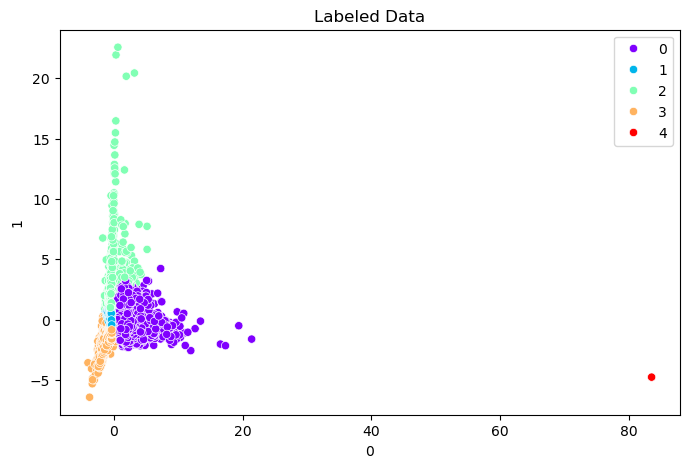

In [50]:
data_labels = clustering_model.labels_
sns.scatterplot(x=0, 
                y=1, 
                data=df_pd_pca_hyer, 
                hue=data_labels,
                palette="rainbow").set_title('Labeled Data')

### Application: clustering images

Theses techniques can be use to reduce the number of colours in a picture

- find a picture you want to reduce the number of colours.
- use `skimages` and `sklearn` to reduce the number of colours in this picture
- from your picture create two pictures with 16 colours what do you notice?

In [ ]:
# install skimage

#Code here

Now let's try to apply KMeans clustering on the simple digits data that can be loaded from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

The goal is to use KMeans to try to identify similar digits without using the original label information.

Start by loading the digits and then finding the KMeans clusters. The digits data consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image.

In [ ]:
# code here

The cluster centroids themselves are 64-dimensional points, and can thus be interpreted as the "typical" digit within the cluster. Plot each cluster center. Hint: use *imshow*

In [ ]:
# code here

For each of the data points we also have access to their real labels (using *digits.target*). This means we can verify if the clustering algorithm split the data in such a way as to predict the original classes. 

Note that the labels of the discovered clusters may not directly match the initial labels in the dataset (they could be permuted). Write code to match each learned cluster label with the true labels of the data found in them.

In [ ]:
# code here

Now compute the accuracy score between the true labels from the data and the predicted ones.

In [ ]:
# code here

Plot the confusion matrix between the predicted labels and the actual labels. Which were the digits that were most often confused with other digits?

In [ ]:
# code here

What if instead of keeping the original 64 features, we perform a projection into 2 dimensions?
Use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing KMeans. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.

Compute the new accuracy.

In [ ]:
# code here